# 

In [6]:
import numpy as np
import bayes3d as b
from tqdm import tqdm
import jax
import jax.numpy as jnp
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
import matplotlib.pyplot as plt
import os
from functools import partial

from mpl_toolkits.axes_grid1 import make_axes_locatable



import jaxopt
from jaxopt import OptaxSolver
import optax

In [7]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7070/static/


In [8]:
def projection(x=0.1, n=1.0, f=50.0):
    return jnp.array([[n/x,    0,            0,              0],
                      [  0,  n/x,            0,              0],
                      [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                      [  0,    0,           -1,              0]])

def translate(x, y, z):
    return jnp.array([[1.0, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])

def xfm_points(points, matrix):
    points = jnp.concatenate([points, jnp.ones((*points.shape[:-1],1))], axis=-1)
    return jnp.matmul(points, matrix.T)

def random_angles(key):
    theta_key, phi_key, omega_key = jax.random.split(key, 3)
    theta = jax.random.choice(theta_key, jnp.linspace(0, 2*jnp.pi, 100))
    phi   = jax.random.choice(phi_key, jnp.linspace(0, 2*jnp.pi, 100))
    omega = jax.random.choice(omega_key, jnp.linspace(0, 2*jnp.pi, 100))
    return theta, phi, omega

def random_translation(key, bbox_len):
    x_key, y_key, z_key = jax.random.split(key, 3)
    translation = jnp.array([0.0, 0.0, -3.2])
    x_del = jax.random.choice(x_key, jnp.linspace(-bbox_len, bbox_len, 100))
    y_del = jax.random.choice(y_key, jnp.linspace(-bbox_len, bbox_len, 100))
    z_del = jax.random.choice(z_key, jnp.linspace(-bbox_len, bbox_len, 100))
    return translation + jnp.array([x_del, y_del, z_del])

def spherical_to_cartesian(theta, phi):
    return jnp.array([jnp.sin(phi)*jnp.cos(theta),
                      jnp.sin(phi)*jnp.sin(theta),
                      jnp.cos(phi)])

def stereo_to_rot(stereo):
    q0, q1, q2, q3 = stereo_to_cartesian(stereo)
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    return jnp.array([[r00, r01, r02],
                      [r10, r11, r12],
                      [r20, r21, r22]])

def get_verts_and_faces(id):
    model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(id).rjust(6, '0') + ".ply")
    mesh = b.utils.scale_mesh(b.utils.load_mesh(mesh_path), 1.0)
    verts, faces = map(jnp.array, (mesh.vertices, mesh.faces))
    return verts, faces

In [36]:
intrinsics = b.Intrinsics(
    height=240,
    width=424,
    fx=216.0, fy=216.0,
    cx=424.0/2, cy=240.0/2,
    near=0.01, far=2000.5
)
jax_renderer = JaxRenderer(intrinsics)

verts_and_faces_list = [get_verts_and_faces(i) for i in range(10,15)]
num_objs = len(verts_and_faces_list)
banana_idx, pitcher_idx, dishsoap_idx, bowl_idx, mug_idx = range(num_objs)

In [18]:
key = jax.random.PRNGKey(2)

In [19]:
verts_and_faces_list[banana_idx]


(Array([[-47.551, -60.295,   5.166],
        [-49.817,  -5.815,  -8.504],
        [-30.09 , -85.954, -12.587],
        ...,
        [  9.81 ,  80.452,  11.273],
        [  7.996,  84.863,   9.165],
        [ 10.651,  83.125,  10.057]], dtype=float32),
 Array([[4039,    1, 1769],
        [1767,    1, 4039],
        [  35, 1427, 1424],
        ...,
        [6504, 7864, 7863],
        [6470, 7865, 7842],
        [6470, 6483, 7865]], dtype=int32))

In [47]:
import trimesh
input_file = "realsense_opt_proj_data_v2/bowl_Depth.raw"
npimg = np.fromfile(input_file, dtype=np.uint16)
imageSize = (240, 424)
npimg = npimg.reshape(imageSize)
print(npimg.shape)
b.get_depth_image(npimg * 1.0)
point_cloud_image = b.unproject_depth_jit(npimg, intrinsics)
b.show_cloud("1", point_cloud_image.reshape(-1,3) / 1000.0)
mesh = trimesh.Trimesh(vertices=verts_and_faces_list[bowl_idx][0] / 1000.0, faces=verts_and_faces_list[bowl_idx][1])
b.show_trimesh("mesh", mesh)

(240, 424)


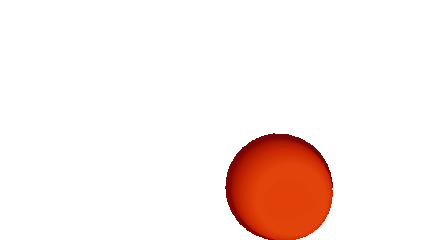

In [53]:
verts_and_faces_list[bowl_idx]
img = jax_renderer.render(*verts_and_faces_list[bowl_idx], b.transform_from_pos(jnp.array([100.0, 100.0, 300.0])), intrinsics)[0][0,...]
b.get_depth_image(img)

In [51]:
b.set_pose("mesh", b.transform_from_pos(jnp.array([0.0, 0.0, 0.5])))

In [44]:
b.show_trimesh("mesh", mesh)

In [22]:
grid_size = 3
thetas = jnp.linspace(0, 2*jnp.pi, grid_size)
phis   = jnp.linspace(0, jnp.pi/2, grid_size)
omegas = jnp.linspace(0, 2*jnp.pi, grid_size)

In [23]:
base_translation = jnp.array([0.0, 0.0, -3.2])
bbox_len = 0.05
xs = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[0]
ys = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[1]
zs = jnp.linspace(-bbox_len, bbox_len, 1) + base_translation[2]
init_params_meshgrid = jnp.meshgrid(thetas, phis, omegas, xs,ys,zs, indexing='ij')
init_params_meshgrid = jnp.array(init_params_meshgrid).reshape(6,-1)
init_params_array = init_params_meshgrid.T

In [21]:
def loss_fn_axis_angle(params, verts, faces, gt_img):
    theta, phi, omega, t_x, t_y, t_z = params
    translation = jnp.array([t_x, t_y, t_z])
    img = render_obj_axis_angle(translation, theta, phi, omega, verts, faces)
    return jnp.mean(jnp.abs(gt_img - img))

In [22]:
lr = 1e-3
num_steps = 1000
num_inits = len(init_params_array)

def estimate_pose(gt_img, init_params_array):
    def optimize(verts, faces, init_params):
        opt = optax.adam(lr)
        solver = OptaxSolver(opt=opt, fun=loss_fn_axis_angle, maxiter=10000)
        init_state = solver.init_state(init_params, verts=verts, faces=faces, gt_img=gt_img)
        def opt_step(i, loop_state):
            params, state, losses = loop_state
            params, state = solver.update(params, state, gt_img=gt_img, verts=verts, faces=faces)
            losses = losses.at[i].set(state.value)
            return params, state, losses 
        params, _, losses = jax.lax.fori_loop(0, num_steps, opt_step, (init_params, init_state, jnp.zeros(num_steps)))
        return losses, params
        
    def optimize_all(i, loop_state):
        jax.debug.print('{i}', i=i)
        loss_trajs, final_losses, final_params = loop_state
        for (obj_id, (verts, faces)) in enumerate(verts_and_faces_list):
            init_params = jax.lax.dynamic_slice(init_params_array, (i, 0), (1, 6)).flatten()
            losses, params = optimize(verts, faces, init_params)
            loss_trajs = loss_trajs.at[i, obj_id, :].set(losses)
            final_losses = final_losses.at[i, obj_id].set(losses[-1])
            final_params = final_params.at[i, obj_id, :].set(params)
        return loss_trajs, final_losses, final_params
        
    final_losses = jnp.zeros((num_inits, num_objs))
    loss_trajs = jnp.zeros((num_inits, num_objs, num_steps))
    final_params = jnp.zeros((num_inits, num_objs, 6))

    return jax.lax.fori_loop(0, len(init_params_array), optimize_all, (loss_trajs, final_losses, final_params))

In [24]:
loss_trajs, final_losses, final_params =jax.jit(estimate_pose)(gt_img, init_params_array)
list(map(lambda x:x.shape, (loss_trajs, final_losses, final_params)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


[(27, 5, 1000), (27, 5), (27, 5, 6)]

In [25]:
best_init_idx, best_obj_idx = jnp.unravel_index(jnp.argmin(final_losses), final_losses.shape)
best_final_params = final_params[best_init_idx, best_obj_idx, :]
best_loss_traj = loss_trajs[best_init_idx, best_obj_idx, :]
best_init_params = init_params_array[best_init_idx, :]

best_init_translation = best_init_params[3:]
best_init_angles = best_init_params[:3]

best_final_translation = best_final_params[3:]
best_final_angles = best_final_params[:3]

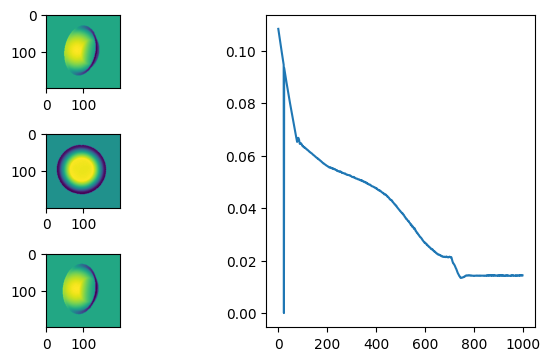

In [26]:
fig, axd = plt.subplot_mosaic([['gt',   'losses'],
                               ['init', 'losses'],
                               ['fin',  'losses']],
                              figsize=(6.0, 3.5), layout="constrained")
axd['gt'].imshow(gt_img[0,...])
axd['init'].imshow(render_obj_axis_angle(best_init_translation, *best_init_angles, *verts_and_faces_list[best_obj_idx])[0,...])
axd['fin'].imshow(render_obj_axis_angle(best_final_translation, *best_final_angles, *verts_and_faces_list[best_obj_idx])[0,...])
axd['losses'].plot(best_loss_traj)